<a href="https://colab.research.google.com/github/GabrielAgune/Data_Science/blob/main/TCC_ProcessamentoDosDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import das bibliotecas utilizadas
import numpy as np
from numpy import dot
import math
from filterpy.kalman import predict, update
import matplotlib.pyplot as plt

In [ ]:
pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=32c5ec5f734786810f8b4275e5b0206ebcec1c1fb999e1541e5c6cbff32834c9
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
float_formartter = "{:.6f}".format
np.set_printoptions(formatter={'float_kind':float_formartter})

#Variáveis utilizadas. São possíveis de serem plotadas nos gráficos após a execução do código
angleyawsg = []
anglepitchs = []
anglepitchsg = []
anglerolls = []
anglerollsg = []
raterollsg =[]
ratepitchsg = []
rateyawsg = []
x_barra1 = []
x_barrasg =[]
kalman0g= []
kalman0grad= []
kalman0 = []
kalman1g= []
kalman1grad= []
kalman1 = []
kalman2g = []
kalman2grad= []
tempos = []
temposg = []
tempografico = []
quartg=[]
q1=[]
q2=[]
tempozero = 0
posinicialg = []
iniciolista =[]
acelX = []
acelY =[]
acelZ =[]
gyroX =[]
gyroY =[]
gyroZ =[]
kX =[]
kY = []
kZ = []
g = []
quart =[]

#Cálculo dos quatérnios através dos ângulos de euler

def get_quaternion_from_euler(roll, pitch, yaw):
  """
  Convert an Euler angle to a quaternion.

  Input
    :param roll: The roll (rotation around x-axis) angle in radians.
    :param pitch: The pitch (rotation around y-axis) angle in radians.
    :param yaw: The yaw (rotation around z-axis) angle in radians.

  Output
    :return qx, qy, qz, qw: The orientation in quaternion [x,y,z,w] format
  """
  qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
  qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
  qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
  qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)





  return [qw, qx, qy, qz]

#função utilizadas nos cálculos do filtro de Kalman
def getCofactor(mat, temp, p, q, n):
    i = 0
    j = 0

    # Looping for each element
    # of the matrix
    for row in range(n):

        for col in range(n):

            # Copying into temporary matrix
            # only those element which are
            # not in given row and column
            if (row != p and col != q):

                temp[i][j] = mat[row][col]
                j += 1

                # Row is filled, so increase
                # row index and reset col index
                if (j == n - 1):
                    j = 0
                    i += 1


# Recursive function for
# finding determinant of matrix.
# n is current dimension of mat[][].
def determinantOfMatrix(mat, n):
    D = 0  # Initialize result

    # Base case : if matrix
    # contains single element
    if (n == 1):
        return mat[0][0]

    # To store cofactors
    temp = [[0 for x in range(n)]
            for y in range(n)]

    sign = 1  # To store sign multiplier

    # Iterate for each
    # element of first row
    for f in range(n):
        # Getting Cofactor of mat[0][f]
        getCofactor(mat, temp, 0, f, n)
        D += (sign * mat[0][f] *
              determinantOfMatrix(temp, n - 1))

        # terms are to be added
        # with alternate sign
        sign = -sign
    return D


def isInvertible(mat, n):
    if (determinantOfMatrix(mat, n) != 0):
        return True
    else:
        return False



i = 0
count = 0
x_barra = []

tempo = []

#Vetores com os valores de calibração do giroscópio nos 3 eixos
rateCalibrationRoll = [-0.09, -3.68, -4.72, -4.2, 7.55, -3.95, 2.65, -26.7, -1.0, -3.65, 0.0, 0.0, 0.0]
rateCalibrationPitch = [0.63, -2.89, 1.93, 2.45, 1.07, -2.74, -3.26, -1.29, 0.72, -0.31, 0.0, 0.0, 0.0]
rateCalibrationYaw = [0.44, -0.42, -0.91, -1.15, 1.87, -0.34, -0.59, 0.65, 0.62, 0.45, 0.0, 0.0, 0.0]




#Vetores com os valores de calibração do acelerômetro nos 3 eixos
acelCalibrationRoll = [1.030966, 1.027678, 1.041764,  1.074233, 1.042983, 1.03, 1.06, 1.04, 1.03, 0.96, 0.0, 0.0, 0.0]
acelCalibrationPitch =[1.003606, 0.983924, 0.987624, 0.98639, 0.98764, 1.0, 0.99, 0.98, 0.99, 1.01, 0.0, 0.0, 0.0]
acelCalibrationYaw = [0.96429, 1.072670, 0.972605,  0.749889, 1.014723, 0.99, 0.74, 1.0, 0.95, 0.89, 0.0, 0.0, 0.0]



#Matrizes utilizadas no filtro de Kalman
#Matriz C do filtro de Kalman
c = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])


#Matriz Xponto do filtro de Kalman
x = np.array([[0.0],
              [0.0],
              [0.0],
              [0.0],
              [0.0],
              [0.0]])

#Matriz u do filtro de Kalman
u = np.array([[0.0],
              [0.0],
              [0.0]])

a_shape = (6, 6)
P = np.zeros(a_shape)

nstate_nobs = (6, 3)
nobs_nobs = (3, 3)
n_z = (3,1)

S = np.zeros(nobs_nobs)
k = np.zeros(nstate_nobs)
z = np.zeros(n_z)

#Leitura do arquivo .txt. Os dados devem separados por vírgula e estar na ordem: acelx,acely,acelz,gyrox,gyroy,gyroz,tempo
with open('IMU.txt') as f:
    contents = f.read()
    dados = contents.split(',')
    print(dados)
    print(len(dados))
    print(len(dados)/7)

#input do número de IMU's utilizados
n_sensor = int(input("Insira o número de sensores: "))
nome_sensores = []
linhasg = ((len(dados))//7)
linhasporsensor = linhasg//n_sensor
dadoscompletos = linhasporsensor*7*n_sensor # controle da quantidade de dados para garantir o mesmo intervalo de amostras que possuo de cada IMU

#input do nome do IMU no Opensim
for i in range(n_sensor):
    nome_sensores.append(str(input("Nome do sensor %d: " %(i+1))))



# for para cada sensor existeste
for num in range(0,n_sensor,1):
  #zerando as variaveis pois estou rodando os calculos do Kalman completo sendo 1 IMU por vez
  kalman0g = []
  kalman1g = []
  kalman2g = []
  kalman0grad =[]
  kalman1grad = []
  kalman2grad =[]
  quartg = []
  anglerollsg = []
  anglepitchsg =[]
  angleyawsg =[]
  raterollsg =[]
  ratepitchsg=[]
  rateyawsg=[]
  ciclo = 0

  x = np.array([[0.0],    #zerando os parametros de Kalman
              [0.0],
              [0.0],
              [0.0],
              [0.0],
              [0.0]])
  u = np.array([[0.0],
              [0.0],
              [0.0]])


  contador =6



  P = np.zeros(a_shape)
  S= np.zeros(nobs_nobs)
  k = np.zeros(nstate_nobs)
  z = np.zeros(n_z)

  if (num ==0):#sensor 1
    print("Sensor 1")
    inicio =0
    count = 0

    # parametros obtidos experimentalmente analisando os gráficos plotados
    n_roll_real = 3
    n_pitch_real = 3
    n_yaw_real = 3

    m_roll_real = 5
    m_pitch_real = 5
    m_yaw_real = 0.1



  if (num==1):#sensor 2
    print("Sensor 2")
    inicio =7
    count = count + 1 # valor referente à posição do vetor dos dados de calibração do sensor 2


    n_roll_real = 3
    n_pitch_real = 3
    n_yaw_real = 3

    m_roll_real = 5
    m_pitch_real = 5
    m_yaw_real = 0.1


  if (num==2):#sensor 3
    inicio =14
    print("Sensor 3")
    count = count+1


    n_roll_real = 3
    n_pitch_real = 3
    n_yaw_real = 3

    m_roll_real = 5
    m_pitch_real = 5
    m_yaw_real = 3


  if (num==3):#sensor 4
    inicio =21
    print("Sensor 4")
    count = count+1


    n_roll_real = 3
    n_pitch_real = 3
    n_yaw_real = 3

    m_roll_real = 5
    m_pitch_real = 5
    m_yaw_real = 0.1

  if (num==4):#sensor 5
    inicio =28
    print("Sensor 5")
    count = count+1


    n_roll_real = 3
    n_pitch_real = 3
    n_yaw_real = 3

    m_roll_real = 5
    m_pitch_real = 5
    m_yaw_real = 0.1


  if (num==5):#sensor 6
    inicio =35
    print("Sensor 6")
    count = count+1


    n_roll_real = 3
    n_pitch_real = 3
    n_yaw_real = 3

    m_roll_real = 5
    m_pitch_real = 5
    m_yaw_real = 0.1


  if (num==6):#sensor 7
    inicio =42
    print("Sensor 7")
    count = count+1


    n_roll_real = 3
    n_pitch_real = 3
    n_yaw_real = 3

    m_roll_real = 5
    m_pitch_real = 5
    m_yaw_real = 0.1

#Para adicionar mais IMU's, apenas replicar a condição do if acima com os parametros daquele IMU em especifico


 #matriz utilizada no filtro de Kalman
  r = np.array([[n_roll_real, 0.0, 0.0],
              [0.0, n_pitch_real, 0.0],
              [0.0, 0.0, n_yaw_real]])

# roda o for a partir da 2º amostra  até a quantidade de dados completos menos a ultima amostra de cada sensor
  for i in range(inicio+(7*n_sensor), (dadoscompletos-(7*n_sensor)), 7*n_sensor):

      Ti =  (float(dados[i+6]) - float(dados[i+6-(7*n_sensor)])) # Ti é o delta T entre a coleta atual e a coleta anterior

    #Matriz Q do filtro de Kalman
      q = np.array([[m_roll_real * Ti * Ti, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, m_pitch_real *Ti * Ti, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, m_yaw_real *Ti *Ti, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, m_roll_real, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, m_pitch_real, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, m_yaw_real]])

     #Matriz B do filtro de Kalman
      b = np.array([[Ti, 0.0, 0.0],
                        [0.0, Ti, 0.0],
                        [0.0, 0.0, Ti],
                        [0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0]])
       #Matriz A do filtro de Kalman
      a = np.array([[1.0, 0.0, 0.0, -Ti, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, -Ti, 0.0],
                        [0.0, 0.0, 1.0, 0.0, 0.0, -Ti],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

    #Calibração do acelerômetro
      dados[i] = (float(dados[i ]) - (acelCalibrationRoll[count] -1))
      dados[i + 1] = (float(dados[i + 1]) - (acelCalibrationPitch[count] -1))
      dados[i + 2] =  (float(dados[i + 2]) - (acelCalibrationYaw[count] -1))

    #Offsets + cálculo dos ângulos de Euler
      if num ==0:
        angleRoll = -10+(math.atan((float(dados[i + 1]) ) / math.sqrt(
            (float(dados[i])) * (float(dados[i]) ) + (
                    (float(dados[i + 2]) ) * (
                    float(dados[i + 2]) ))))*(1/(3.14159265/180)))

        anglePitch = -105+ (-math.atan((float(dados[i]) ) / math.sqrt(
              ((float(dados[i + 1]) ) * (float(dados[i + 1]) )) + (
                      (float(dados[i + 2]) ) * (
                      float(dados[i + 2]) ))))*(1/(3.14159265/180)))

        angleYaw =  -80+(math.atan(((float(dados[i + 2]))/math.sqrt((float(dados[i]))*(float(dados[i]))+(float(dados[i+1]))*(float(dados[i+1]))))))*(1/(3.14159265/180))

      if num ==1:
        angleRoll = -10+ (math.atan((float(dados[i + 1]) ) / math.sqrt(
            (float(dados[i])) * (float(dados[i]) ) + (
                    (float(dados[i + 2]) ) * (
                    float(dados[i + 2]) ))))*(1/(3.14159265/180)))

        anglePitch = -100+ (-math.atan((float(dados[i]) ) / math.sqrt(
              ((float(dados[i + 1]) ) * (float(dados[i + 1]) )) + (
                      (float(dados[i + 2]) ) * (
                      float(dados[i + 2]) ))))*(1/(3.14159265/180)))

        angleYaw = -100+(math.atan(((float(dados[i + 2]))/math.sqrt((float(dados[i]))*(float(dados[i]))+(float(dados[i+1]))*(float(dados[i+1]))))))*(1/(3.14159265/180))

      if num ==2:
        angleRoll = 0+(math.atan((float(dados[i + 1]) ) / math.sqrt(
            (float(dados[i])) * (float(dados[i]) ) + (
                    (float(dados[i + 2]) ) * (
                    float(dados[i + 2]) ))))*(1/(3.14159265/180)))



        anglePitch = -110+ (-math.atan((float(dados[i]) ) / math.sqrt(
              ((float(dados[i + 1]) ) * (float(dados[i + 1]) )) + (
                      (float(dados[i + 2]) ) * (
                      float(dados[i + 2]) ))))*(1/(3.14159265/180)))


        angleYaw =  -70+(math.atan(((float(dados[i + 2]))/math.sqrt((float(dados[i]))*(float(dados[i]))+(float(dados[i+1]))*(float(dados[i+1]))))))*(1/(3.14159265/180))

      if num ==3:
        angleRoll = -20+(math.atan((float(dados[i + 1]) ) / math.sqrt(
            (float(dados[i])) * (float(dados[i]) ) + (
                    (float(dados[i + 2]) ) * (
                    float(dados[i + 2]) ))))*(1/(3.14159265/180)))

        anglePitch = -110+ (-math.atan((float(dados[i]) ) / math.sqrt(
              ((float(dados[i + 1]) ) * (float(dados[i + 1]) )) + (
                      (float(dados[i + 2]) ) * (
                      float(dados[i + 2]) ))))*(1/(3.14159265/180)))

        angleYaw =  -90+(math.atan(((float(dados[i + 2]))/math.sqrt((float(dados[i]))*(float(dados[i]))+(float(dados[i+1]))*(float(dados[i+1]))))))*(1/(3.14159265/180))


      if num ==4:
        angleRoll = -90+(math.atan((float(dados[i + 1]) ) / math.sqrt(
            (float(dados[i])) * (float(dados[i]) ) + (
                    (float(dados[i + 2]) ) * (
                    float(dados[i + 2]) ))))*(1/(3.14159265/180)))

        anglePitch = 90+ (-math.atan((float(dados[i]) ) / math.sqrt(
              ((float(dados[i + 1]) ) * (float(dados[i + 1]) )) + (
                      (float(dados[i + 2]) ) * (
                      float(dados[i + 2]) ))))*(1/(3.14159265/180)))

        angleYaw =  0+(math.atan(((float(dados[i + 2]))/math.sqrt((float(dados[i]))*(float(dados[i]))+(float(dados[i+1]))*(float(dados[i+1]))))))*(1/(3.14159265/180))

      if num==5:
        angleRoll = 0+(math.atan((float(dados[i + 1]) ) / math.sqrt(
            (float(dados[i])) * (float(dados[i]) ) + (
                    (float(dados[i + 2]) ) * (
                    float(dados[i + 2]) ))))*(1/(3.14159265/180)))

        anglePitch = 0+ (-math.atan((float(dados[i]) ) / math.sqrt(
              ((float(dados[i + 1]) ) * (float(dados[i + 1]) )) + (
                      (float(dados[i + 2]) ) * (
                      float(dados[i + 2]) ))))*(1/(3.14159265/180)))

        angleYaw =  0+(math.atan(((float(dados[i + 2]))/math.sqrt((float(dados[i]))*(float(dados[i]))+(float(dados[i+1]))*(float(dados[i+1]))))))*(1/(3.14159265/180))





      #Vetor anglerolls armazena os valores do AngleRoll
      anglerollsg.append(angleRoll)
      #Vetor anglepitchsg armazena os valores do AnglePitch
      anglepitchsg.append(anglePitch)
      #Vetor angleyawsg armazena os valores do AngleYaw
      angleyawsg.append(angleYaw)



      TT =  (float(dados[i+6]) - float(dados[6])) # TT é o tempo desde o começo do programa

      if num ==0:
        #Variável tempografico utilizada como escala no eixo X dos gráficos
        tempografico.append((float(dados[i+6]) - float(dados[6])))

      if num == (n_sensor-1):
        #Variável temposg é o tempo do último IMU utilizado que será o tempo considerado no arquivo .sto
        temposg.append(float(TT))




  #Matriz Z do filtro de Kalman (saída) recebe os valores do acelerometro
      z[0] = angleRoll
      z[1] = anglePitch
      z[2] = angleYaw



     #Calibração dos valores do giroscópio
      rateRoll = ((float(dados[i + 3]) ) - rateCalibrationRoll[count])
      ratePitch =  ((float(dados[i + 4]) ) - rateCalibrationPitch[count])
      rateYaw = ((float(dados[i + 5]) ) - rateCalibrationYaw[count])

    #Vetores que armazenam os valores dos dados do giroscópio
      raterollsg.append(rateRoll)
      ratepitchsg.append(ratePitch)
      rateyawsg.append(rateYaw)

    #Matriz u do filtro de Kalman (entrada) recebe os valores do giroscópio
      u[0] = rateRoll
      u[1] = ratePitch
      u[2] = rateYaw



     #Início dos cálculo do filtro de Kalman
     #Etapa da predição:

      x, P = predict(x, P, a, q, u, b)
      '''print("----------------Predict-----------------")
      print('x =', x)
      print('P =', P)'''

      #Etapa da atualização:

      S = dot(dot(c, P), c.T) + r

      is_nosingular = determinantOfMatrix(S, 2)

      k = dot(dot(P, c.T), S)

      if is_nosingular:
          #print("Entrou no Kalman")
          x, P = update(x, P, z, r, c)
          #print("----------------Update-----------------")
          #print('x =', x)
          #print('P =', P)
          #print("update resultado")
          #print(x)
          #print("kalman0g ")

        #Variáveis do ângulos reais em graus calculados pelo filtro de Kalman
          kalman0g.append((x[0][0]))
          kalman1g.append((x[1][0]))
          kalman2g.append( (x[2][0]))

        #Variáveis do ângulos reais em radianos calculados pelo filtro de Kalman
          kalman0grad.append( (float(kalman0g[ciclo])*(3.14159265/180)))
          kalman1grad.append((float(kalman1g[ciclo])*(3.14159265/180)))
          kalman2grad.append((float(kalman2g[ciclo])*(3.14159265/180)))

        #Função que transforma os ângulos reais do filtro de Kalman em quatérnios
          quartg.append(get_quaternion_from_euler(float(kalman0grad[ciclo]),float(kalman1grad[ciclo]),float(kalman2grad[ciclo])))


          ciclo = ciclo +1





  #armazenando os dados para plotar nos graficos posteriormente
  acelX.append(anglerollsg)
  acelY.append(anglepitchsg)
  acelZ.append(angleyawsg)
  gyroX.append(raterollsg)
  gyroY.append(ratepitchsg)
  gyroZ.append(rateyawsg)
  kX.append(kalman0g)
  kX.append(kalman0grad)
  kY.append(kalman1g)
  kY.append(kalman1grad)
  kZ.append(kalman2g)
  kZ.append(kalman2grad)
  quart.append(quartg)



#Criando o arquivo .sto da posição inicial a ser utilizado no Opensim
f1 = open('posicao_inicial.sto', 'w')   # estrutura: 1 tempo e os quartenions de todos os sensores
f1.write("DataRate=100.000000\nDataType=Quaternion\nversion=3\nOpenSimVersion=4.4\nendheader\n")
f1.write('time')
for l in range(len(nome_sensores)):
    f1.write('\t' + nome_sensores[l])
f1.write("\n")
f1.write(str(temposg[50])) #tempo da n-ésima amostra. Visualizar no gráfico o instante de tempo que o Kalman estabilizou e levar em consideração para alterar esse valor
for ll in range(0,len(nome_sensores),1):
  f1.write("\t" + str(quart[ll][50][0]) + "," + str(quart[ll][50][1]) + "," + str(quart[ll][50][2]) + "," + str(quart[ll][50][3]))


#Criando o arquivo .sto do movimento
f1 = open('opensimTeste.sto', 'w')   # estrutura: 1 tempo -> quartenions de todos os sensores     tempo -> quartenions de todos os sensores
f1.write("DataRate=100.000000\nDataType=Quaternion\nversion=3\nOpenSimVersion=4.4\nendheader\n")
f1.write('time')
#nome dos sensores no Opensim
for l in range(len(nome_sensores)):
    f1.write('\t' + nome_sensores[l])
f1.write("\n")

for k in range(20, len(temposg)-1,1): #vai de 20 até o numero de amostras coletadas (temposg) de 1 em 1. Alterar esse valor também de acordo com a gravação
  f1.write(str(temposg[k]))
  for ll in range(0,len(nome_sensores),1):
    f1.write("\t" + str(quart[ll][k][0]) + "," + str(quart[ll][k][1]) + "," + str(quart[ll][k][2]) + "," + str(quart[ll][k][3]))
  f1.write("\n")



print("terminou")

['0.984985', '0.236816', '-0.18701', '-4.8702', '2.42748', '0', '0.002', '0.998047', '0.168945', '0.237061', '-3.084', '1.66412', '1.57252', '0.009', '0.980957', '-0.05273', '-0.3512', '1.9084', '-1.0687', '0.534351', '0.016', '1.00464', '0.348389', '-0.27051', '2.35115', '-3.1603', '-0.0458', '0.023', '0.061401', '0.982788', '-0.02222', '-25.832', '-1.084', '0.931298', '0.03', '0.985718', '0.236206', '-0.18823', '-5.084', '2.39695', '0.351145', '0.059', '0.998657', '0.166992', '0.240601', '-3.3893', '1.80153', '1.81679', '0.066', '0.980103', '-0.05176', '-0.34766', '1.58779', '-0.64122', '1.1145', '0.073', '1.00525', '0.349854', '-0.26562', '3.43511', '-2.9313', '0.274809', '0.08', '0.059204', '0.974487', '-0.02429', '-25.603', '-1.5115', '1.31298', '0.087', '0.986694', '0.234375', '-0.18591', '-5.8626', '2.29008', '0.564885', '0.119', '1.00073', '0.168091', '0.237305', '-2.7176', '1.66412', '2.35115', '0.126', '0.980713', '-0.05676', '-0.34924', '-0.03053', '-0.99237', '1.23664', '0.

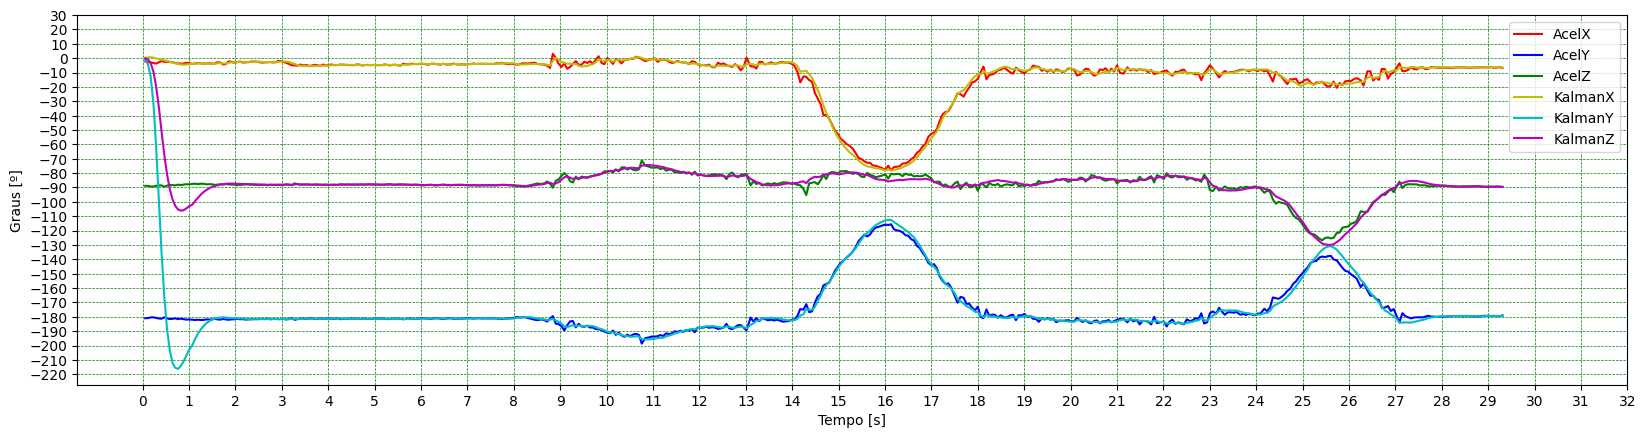

In [ ]:
# @title Plot gráfico angulo acelerometro x Angulo real Kalman em graus
a = 2
n = 4 #n=0 -> kalman IMU 0 em graus,   n=1 -> kalman IMU 0 em rad   n=2 -> kalman IMU 1 em graus ...
#a 0 1 2 3 4
#n 0 2 4 6 8
plt.figure().set_figwidth(20)
plt.plot(tempografico,acelX[a], color ='r',label = 'AcelX') #vermelho
plt.plot(tempografico,acelY[a], color ='b',label = 'AcelY') # azul escuro
plt.plot(tempografico,acelZ[a], color ='g',label ='AcelZ') #verde
plt.plot(tempografico,kX[n], color ='y',label ='KalmanX') # amarelo
plt.plot(tempografico,kY[n],color = 'c',label ='KalmanY' ) # azul claro
plt.plot(tempografico,kZ[n],color = 'm',label ='KalmanZ') #rosa
plt.xlabel("Tempo [s]")
plt.ylabel("Graus [º]")
plt.legend()
plt.xticks(np.arange(0, 33, step=1))
plt.yticks(np.arange(-220, 40, step=10))
plt.grid(color ='g', linestyle = '--', linewidth = 0.5)

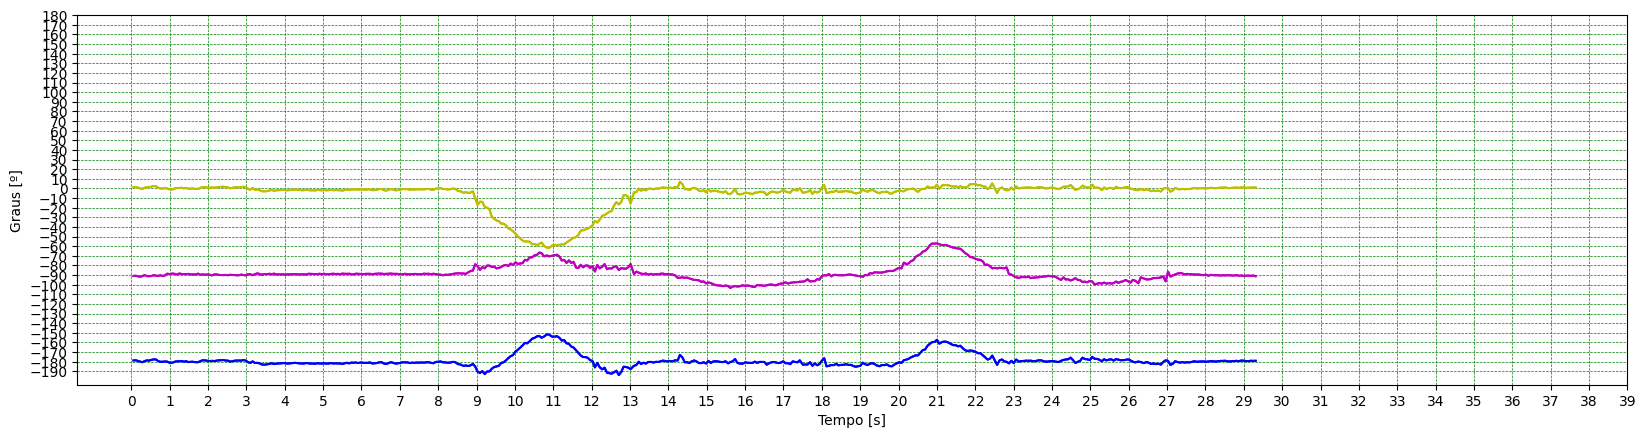

In [ ]:
# @title Plot gráfico Angulo acelerometro em graus Sensor n
n = 3 #n=0 -> angulo acelerometro IMU 0 em graus,   n=1 -> angulo acelerometro  IMU 1 em graus ...
b = 3
plt.figure().set_figwidth(20)
plt.plot(tempografico,acelX[n], color ='y') # amarelo
plt.plot(tempografico,acelY[n], color ='b') # azul escuro
plt.plot(tempografico,acelZ[n],color = 'm') #rosa
plt.plot(tempografico,acelX[b], color ='y') # amarelo
plt.plot(tempografico,acelY[b], color ='b') # azul escuro
plt.plot(tempografico,acelZ[b],color = 'm') #rosa
plt.xlabel("Tempo [s]")
plt.ylabel("Graus [º]")
plt.xticks(np.arange(0, 40, step=1))
plt.yticks(np.arange(-190, 190, step=10))
plt.grid(color ='g', linestyle = '--', linewidth = 0.5)
#tempografico

(6.0, 45.0, -270.0, 120.0)

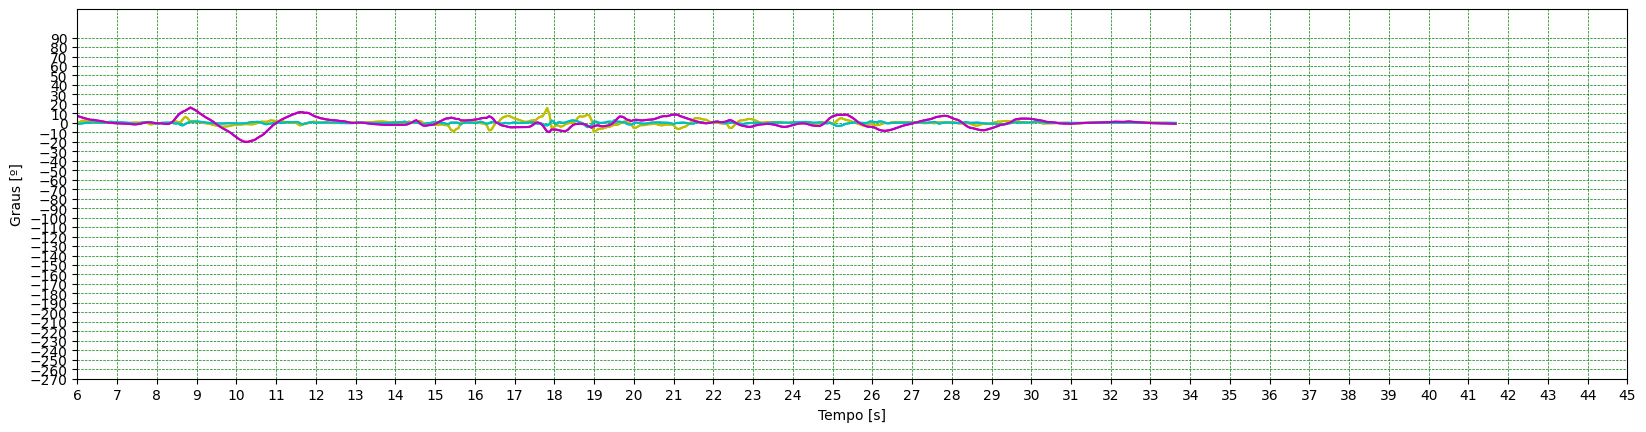

In [ ]:
# @title Plot gráfico angulo  Kalman em graus

n = 6 #n=0 -> kalman IMU 0 em graus,   n=1 -> kalman IMU 0 em rad   n=2 -> kalman IMU 1 em graus ...
plt.figure().set_figwidth(20)
m=6
plt.plot(tempografico,kX[n], color ='y') # amarelo
plt.plot(tempografico,kY[n],color = 'c' ) # azul claro
plt.plot(tempografico,kZ[n],color = 'm') #rosa
plt.plot(tempografico,kX[m], color ='y') # amarelo
plt.plot(tempografico,kY[m],color = 'c' ) # azul claro
plt.plot(tempografico,kZ[m],color = 'm') #rosa
plt.xlabel("Tempo [s]")
plt.ylabel("Graus [º]")
plt.xticks(np.arange(0, 70, step=1))
plt.yticks(np.arange(-270, 100, step=10))
plt.grid(color ='g', linestyle = '--', linewidth = 0.5)
plt.axis([6,45,-270,120]) #escolhe o intervalo/recorte que ira mostrar o grafico


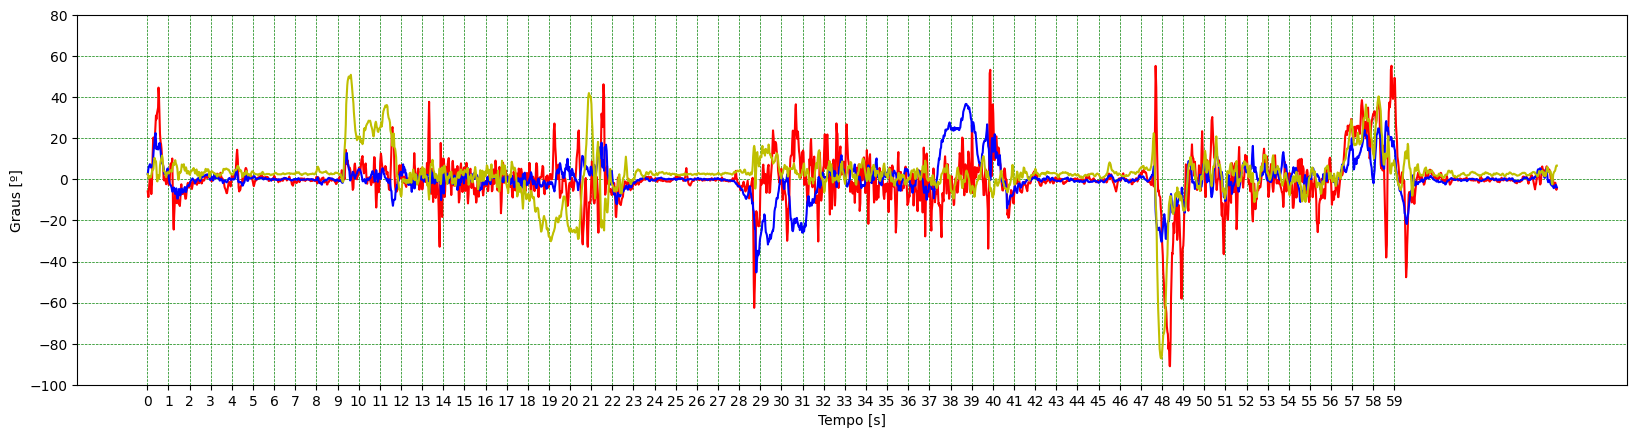

In [ ]:
# @title Plot gráfico giroscopio x tempo
n=1
plt.figure().set_figwidth(20)
plt.plot(tempografico,gyroX[n], color ='r') #vermelho
plt.plot(tempografico,gyroY[n], color ='b') # azul escuro
plt.plot(tempografico,gyroZ[n], color ='y') #amarelo

plt.xlabel("Tempo [s]")
plt.ylabel("Graus [º]")
plt.xticks(np.arange(0, 60, step=1))
plt.yticks(np.arange(-100, 100, step=20))
plt.grid(color ='g', linestyle = '--', linewidth = 0.5)
#plt.axis([0,15,-20,70]) #escolhe o intervalo/recorte que ira mostrar o grafico